Original size (W,H): (960, 686)
Padded size (W,H): (960, 688)
torch.Size([1, 2585, 1280])
CLS shape: torch.Size([1, 1280])
Patch map shape: torch.Size([1, 43, 60, 1280])


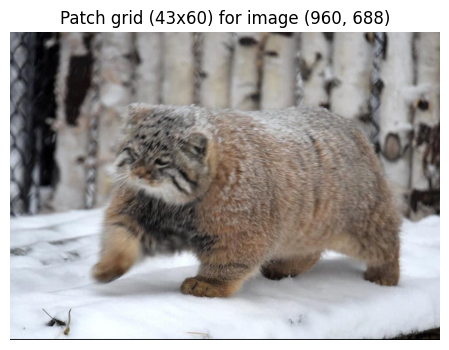

In [1]:
# pip install transformers torch pillow requests --upgrade

import torch
import numpy as np
from PIL import Image, ImageOps
from transformers import AutoImageProcessor, AutoModel
import requests

# ---------------------------------------------------------
# 1. Load image
# ---------------------------------------------------------
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
print("Original size (W,H):", image.size)

# ---------------------------------------------------------
# 2. Load model and processor
# ---------------------------------------------------------
MODEL_ID = "facebook/dinov3-vith16plus-pretrain-lvd1689m"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoImageProcessor.from_pretrained(MODEL_ID)
model = AutoModel.from_pretrained(MODEL_ID).to(device).eval()

# Disable auto-resize / crop so we control input size
processor.do_resize = False
processor.do_center_crop = False

# ---------------------------------------------------------
# 3. Pad to multiple of patch size (typically 14 or 16)
# ---------------------------------------------------------
patch_size = getattr(model.config, "patch_size", 16)

def pad_to_multiple(img_pil, multiple):
    w, h = img_pil.size
    pad_w = (multiple - (w % multiple)) % multiple
    pad_h = (multiple - (h % multiple)) % multiple
    if pad_w == 0 and pad_h == 0:
        return img_pil
    return ImageOps.expand(img_pil, border=(0, 0, pad_w, pad_h), fill=0)

img_padded = pad_to_multiple(image, patch_size)
print("Padded size (W,H):", img_padded.size)

# ---------------------------------------------------------
# 4. Forward through model
# ---------------------------------------------------------
inputs = processor(images=img_padded, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.inference_mode():
    outputs = model(**inputs)

# ---------------------------------------------------------
# 5. Separate CLS / patch features
# ---------------------------------------------------------
last_hidden = outputs.last_hidden_state              # [1, 1+num_reg+N, D]
print(last_hidden.shape)
num_reg = getattr(model.config, "num_register_tokens", 0)
cls_token = last_hidden[:, 0, :]                     # [1, D]
patch_tokens = last_hidden[:, 1+num_reg:, :]         # [1, N, D]

# Patch grid size (H', W')
W, H = img_padded.size
gh, gw = H // patch_size, W // patch_size
assert patch_tokens.shape[1] == gh * gw
patch_map = patch_tokens.reshape(1, gh, gw, -1)      # [1, H', W', D]

print(f"CLS shape: {cls_token.shape}")               # [1, hidden_dim]
print(f"Patch map shape: {patch_map.shape}")         # [1, gh, gw, hidden_dim] e.g. [1, 44, 52, 1024]

# ---------------------------------------------------------
# 6. Optional: visualize patch grid resolution
# ---------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.title(f"Patch grid ({gh}x{gw}) for image {img_padded.size}")
plt.imshow(np.array(img_padded))
plt.axis("off")
plt.show()


In [10]:
inputs['pixel_values'].shape

torch.Size([1, 3, 688, 960])

(2580, 1280)
(2580, 1280) (2580, 3) (43, 60, 3)


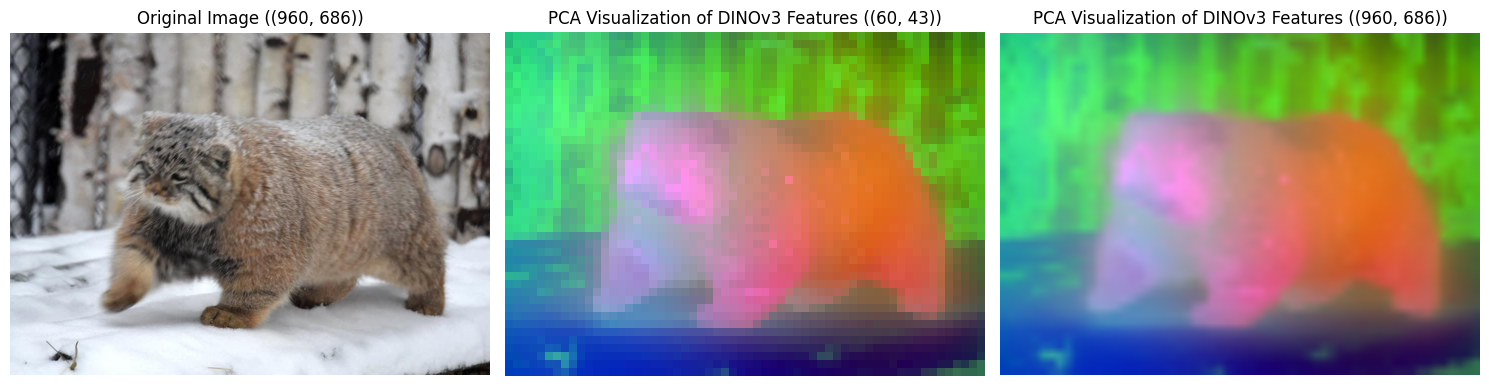

In [3]:
from sklearn.decomposition import PCA

patch_features = patch_tokens[0].cpu().numpy()
print(patch_features.shape)

pca = PCA(n_components=3)
features_pca = pca.fit_transform(patch_features)

pca_image = features_pca.reshape((gh, gw, 3))
print(patch_features.shape, features_pca.shape, pca_image.shape)

pca_image_normalized = np.zeros_like(pca_image)
for i in range(3):
    channel = pca_image[:, :, i]
    pca_image_normalized[:, :, i] = (channel - channel.min()) / (channel.max() - channel.min())

pca_pil_image = Image.fromarray((pca_image_normalized * 255).astype(np.uint8))

pca_pil_image_bilinear = pca_pil_image.resize(image.size, Image.Resampling.BILINEAR)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(image)
axes[0].set_title(f"Original Image ({image.size})")
axes[0].axis('off')

axes[1].imshow(pca_pil_image)
axes[1].set_title(f"PCA Visualization of DINOv3 Features ({pca_pil_image.size})")
axes[1].axis('off')

# BILINEAR
axes[2].imshow(pca_pil_image_bilinear)
axes[2].set_title(f"PCA Visualization of DINOv3 Features ({pca_pil_image_bilinear.size})")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [4]:
def feature_stats(x, use_minmax=True, use_skew=True, use_kurt=True):
    """
    x: [D, H, W, C]
    """
    feat_mean = torch.mean(x, -1).unsqueeze(-1)
    feat_std = torch.std(x, -1).unsqueeze(-1)
    feats = torch.cat([feat_mean, feat_std], dim=3)
    names = ["AVG", "SD"]
    
    if use_minmax:
        feat_min = torch.min(x, -1).values.unsqueeze(-1)
        feat_max = torch.max(x, -1).values.unsqueeze(-1)
        feats = torch.cat([feats, feat_min, feat_max], dim=3)
        names.extend(["MIN", "MAX"])
    if use_skew or use_kurt:
        z = (x - feat_mean) / (feat_std + 1e-12)
        if use_skew:
            feat_skew = (z ** 3).mean(-1).unsqueeze(-1)
            feats = torch.cat([feats, feat_skew], dim=3)
            names.append("SKEW")
        if use_kurt:
            feat_kurt = (z ** 4).mean(-1).unsqueeze(-1)
            feats = torch.cat([feats, feat_kurt], dim=3)
            names.append("KURT")

    return feats, names

torch.Size([1, 43, 60, 6])


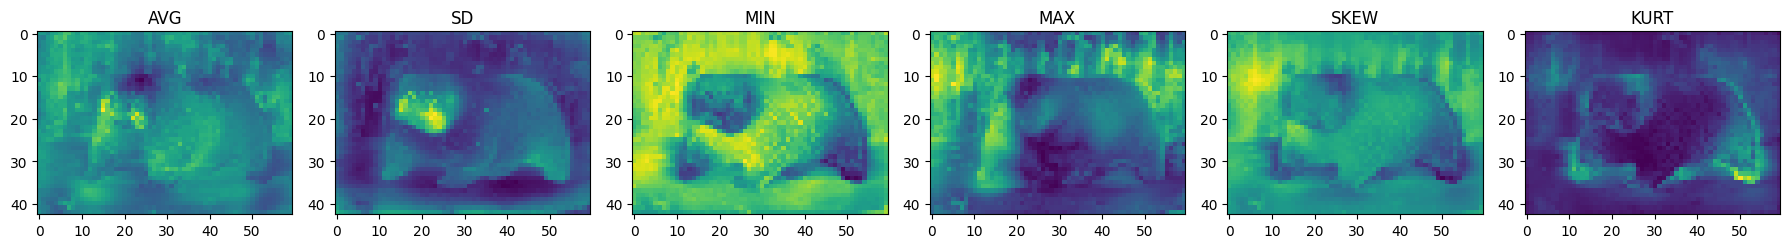

In [5]:
feats, names = feature_stats(patch_map)
print(feats.shape)

num_feat = feats.shape[-1]
fig, axes = plt.subplots(1, num_feat, figsize=(3*num_feat, 3))

for feat_dx in range(num_feat):
    axes[feat_dx].set_title(names[feat_dx])
    axes[feat_dx].imshow(feats[0, :, :, feat_dx].cpu().numpy())

plt.tight_layout()
plt.show()